In [3]:
import os, math, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------------------
# 1) Dataset setup (60% train, 10% val, 30% test)
# ----------------------------
base_path = r"D:\MajorProjectChestXRay\Chest x rays"
img_size = (256, 256)
batch_size = 32

# Step 1: Create 70% train+val and 30% test split
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.3,      
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    base_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="rgb"
)
# Get class names from the data

class_names = train_val_ds.class_names
print(f"Found classes: {class_names}")
num_classes = len(class_names)


# Step 2: Split train_val_ds into 60% train, 10% validation
train_size = 60 / (60 + 10)   # = 0.8571
train_batches = int(tf.data.experimental.cardinality(train_val_ds).numpy() * train_size)

train_ds = train_val_ds.take(train_batches)
val_ds = train_val_ds.skip(train_batches)
def one_hot_labels(image, label):
    label = tf.one_hot(label, depth=num_classes)
    return image, label


train_ds = train_ds.map(one_hot_labels)
val_ds = val_ds.map(one_hot_labels)
test_ds = test_ds.map(one_hot_labels)
# Step 3: Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


print(f"Train batches: {train_batches}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")


Found 11919 files belonging to 4 classes.
Using 8344 files for training.
Found 11919 files belonging to 4 classes.
Using 3575 files for validation.
Found classes: ['Covid19', 'Normal', 'Pneumonia', 'Tuberculosis']
Train batches: 223
Validation batches: 38
Test batches: 112


In [4]:
import os

# Path to dataset
base_path = r"D:\MajorProjectChestXRay\Chest x rays"

# List of classes
classes = ["Covid19", "Normal", "Pneumonia", "Tuberculosis"]

# Count images in each class
for cls in classes:
    cls_path = os.path.join(base_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f"{cls}: {num_images} images")

Covid19: 3566 images
Normal: 3450 images
Pneumonia: 4223 images
Tuberculosis: 680 images


In [5]:
from tensorflow.keras import backend as K
from IPython.display import FileLink
import os


# --- 2. Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

"""
# --- 3. Model Building (Using MobileNetV2) ---

base_model = keras.applications.MobileNetV2(
    include_top=False, 
    input_shape=(256, 256, 3), 
    weights="imagenet"
)
base_model.trainable = True

# Freeze the first 80% of layers
for layer in base_model.layers[:int(0.8 * len(base_model.layers))]:
    layer.trainable = False

# Build the final model
inputs = keras.Input(shape=(256, 256, 3)) 
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)

# --- 4. Focal Loss Function ---
def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# --- 5. Compile Model ---
INIT_LR = 5e-4
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=INIT_LR),
    loss=focal_loss(),
    metrics=["accuracy", keras.metrics.Recall(name="recall"), keras.metrics.Precision(name="precision")]
)

# --- 6. Class Weights ---
label2id = {label: idx for idx, label in enumerate(class_names)}
class_weight = {
    label2id["Covid19"]: 1.5,
    label2id["Normal"]: 0.7,
    label2id["Pneumonia"]: 1.0,
    label2id["Tuberculosis"]: 1.8
}

# --- 7. Callbacks ---
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)
ckpt = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# --- 8. Train the Model ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr, ckpt],
    verbose=1
)

# --- 9. Save the BEST Model ---
print("Training finished.")
print("Loading best weights from checkpoint...")
model = keras.models.load_model(
    "best_model.keras", 
    custom_objects={"loss": focal_loss}
)

# Now save this best model to your final file
model.save("MobileNetV2_chestxray_model.keras")
print("Best model saved successfully as MobileNetV2_chestxray_model.keras")

FileLink("MobileNetV2_chestxray_model.keras")

"""

'\n# --- 3. Model Building (Using MobileNetV2) ---\n\nbase_model = keras.applications.MobileNetV2(\n    include_top=False, \n    input_shape=(256, 256, 3), \n    weights="imagenet"\n)\nbase_model.trainable = True\n\n# Freeze the first 80% of layers\nfor layer in base_model.layers[:int(0.8 * len(base_model.layers))]:\n    layer.trainable = False\n\n# Build the final model\ninputs = keras.Input(shape=(256, 256, 3)) \nx = data_augmentation(inputs)\nx = keras.applications.mobilenet_v2.preprocess_input(x)\nx = base_model(x) \nx = layers.GlobalAveragePooling2D()(x)\nx = layers.Dropout(0.5)(x)\noutputs = layers.Dense(len(class_names), activation="softmax")(x)\nmodel = keras.Model(inputs, outputs)\n\n# --- 4. Focal Loss Function ---\ndef focal_loss(gamma=2., alpha=0.75):\n    def loss(y_true, y_pred):\n        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())\n        cross_entropy = -y_true * K.log(y_pred)\n        weight = alpha * K.pow(1 - y_pred, gamma)\n        return K.sum(weight * c

In [ ]:
from tensorflow import keras

model = keras.models.load_model(r"D:\MajorProjectChestXRay\MobileNetV2_chestxray_model.keras", compile=False)
print(" Pretrained model loaded successfully.")

# Recompile (optional) if you need metrics/loss for evaluation
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)


 Pretrained model loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

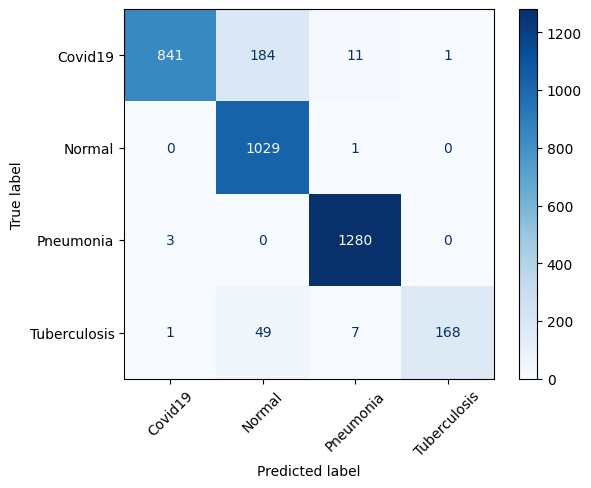

              precision    recall  f1-score   support

     Covid19       1.00      0.81      0.89      1037
      Normal       0.82      1.00      0.90      1030
   Pneumonia       0.99      1.00      0.99      1283
Tuberculosis       0.99      0.75      0.85       225

    accuracy                           0.93      3575
   macro avg       0.95      0.89      0.91      3575
weighted avg       0.94      0.93      0.93      3575



In [7]:
# 8) Evaluation


y_true = []
y_pred = []
for images, labels in test_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


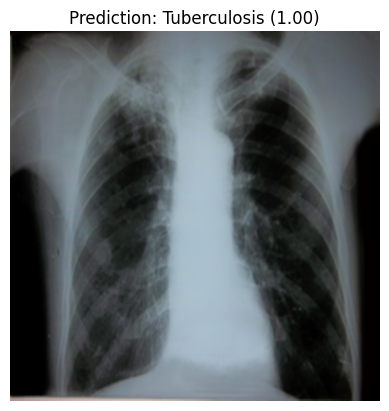

Predicted: Tuberculosis with confidence: 0.9999368


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and predict on new image
def predict_new_image(img_path, model, img_size=(256,256)):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  

    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Predict
    probs = model.predict(img_array)[0]
    pred_idx = np.argmax(probs)
    pred_class = class_names[pred_idx]
    confidence = np.max(probs)

    # Show image + prediction
    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis("off")
    plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
    plt.show()

    return pred_class, confidence

# Example usage (replace with your own file path)
new_img_path = r"D:\MajorProjectChestXRay\Chest x rays_test\Tuberculosis_test\Tuberculosis-681.png"
pred_class, conf = predict_new_image(new_img_path, model)
print("Predicted:", pred_class, "with confidence:", conf)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

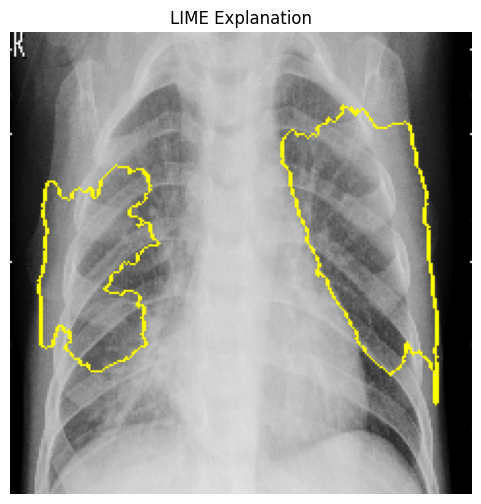

In [13]:
#!pip install lime
from lime import lime_image
import lime
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


# 2. Prepare a pretrained model
model = tf.keras.applications.MobileNetV2(weights="imagenet")
preprocess = tf.keras.applications.mobilenet_v2.preprocess_input
decode = tf.keras.applications.mobilenet_v2.decode_predictions

# Load a single custom image
img_path = r"D:\MajorProjectChestXRay\Chest x rays_test\Pneumonia_test\person1906_bacteria_4803.jpeg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)


# 4. Define LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    image=img,
    classifier_fn=lambda x: model.predict(preprocess(x)),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# 5. Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6, 6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()


[INFO] Using last conv layer: Conv_1


c:\Users\priya\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_680']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\priya\AppData\Local\Temp\ipykernel_8544\390469701.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")(np.arange(256))[:, :3]


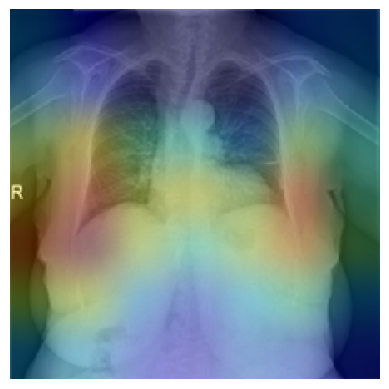

In [14]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from matplotlib import cm

# Function: Grad-CAM Generator
def gradcam(img_path, model, img_size=(224, 224), alpha=0.4):
    # Automatically detect last convolutional layer
    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break
    if last_conv is None:
        raise ValueError("No Conv2D layer found in the model!")

    print(f"[INFO] Using last conv layer: {last_conv}")

    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    x = np.expand_dims(image.img_to_array(img), axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        grads = tape.gradient(preds[:, class_idx], conv_out)

    # Generate heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.squeeze(conv_out[0] @ pooled_grads[..., tf.newaxis])
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Overlay on original image
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")(np.arange(256))[:, :3]
    jet_heatmap = image.array_to_img(jet[heatmap])
    jet_heatmap = jet_heatmap.resize(img.size)
    jet_heatmap = image.img_to_array(jet_heatmap)
    superimposed = image.array_to_img(jet_heatmap * alpha + image.img_to_array(img))

    plt.imshow(superimposed)
    plt.axis('off')
    plt.show()


# ------------------------------
# Example Usage
# ------------------------------


# Pick one image (e.g., from Covid19 folder)
test_img_path = r"D:\MajorProjectChestXRay\Chest x rays_test\Covid19_test\COVID-3575.png"
# Run Grad-CAM (ensure 'model' is your trained model)
gradcam(test_img_path, model)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

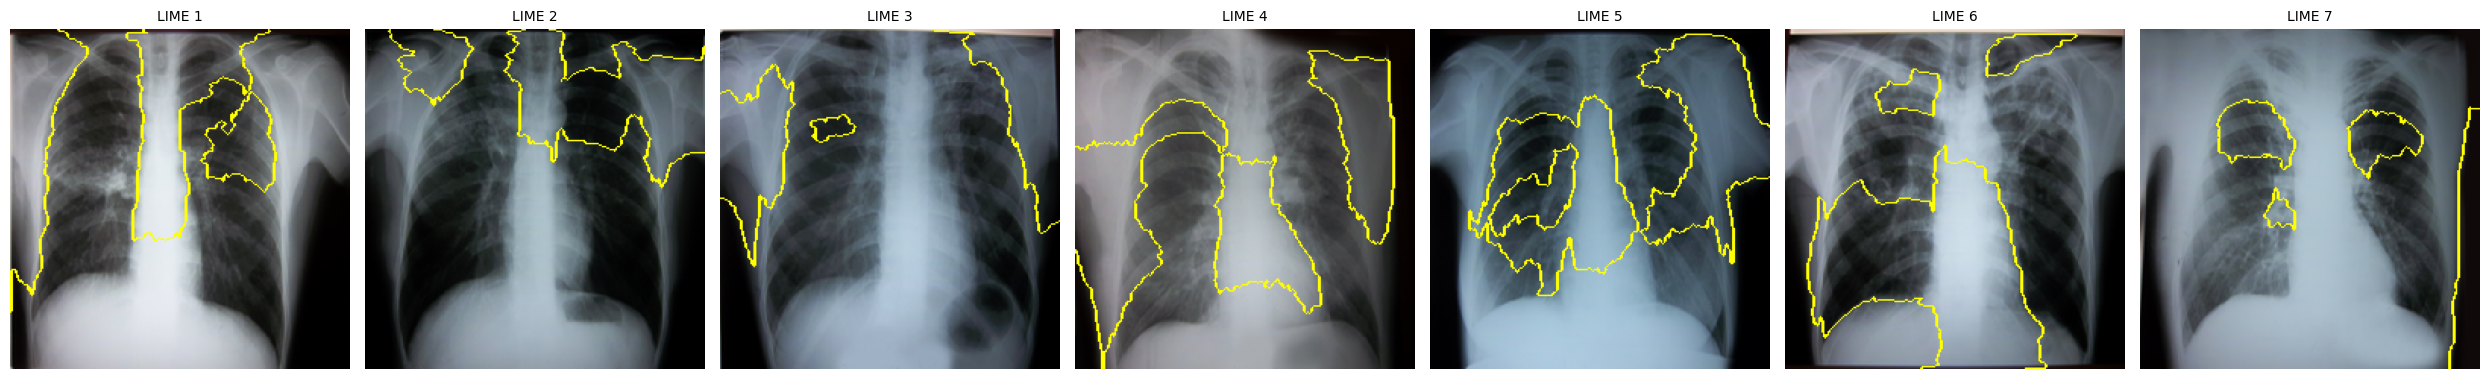

In [15]:
import random
import os

# Folder containing test images
tuberculosis_folder = r"D:\MajorProjectChestXRay\Chest x rays_test\Tuberculosis_test"

all_images = [os.path.join(tuberculosis_folder, f) for f in os.listdir(tuberculosis_folder)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_images = random.sample(all_images, 7)

#  LIME VISUALIZATIONS
fig, axes = plt.subplots(1, 7, figsize=(25, 5))
for i, img_path in enumerate(sample_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_arr = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)

    explanation = explainer.explain_instance(
        image=img_arr,
        classifier_fn=lambda x: model.predict(preprocess(x)),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    axes[i].imshow(mark_boundaries(temp / 255.0, mask))
    axes[i].set_title(f"LIME {i+1}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

C:\Users\priya\AppData\Local\Temp\ipykernel_8544\2712767124.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")(np.arange(256))[:, :3]


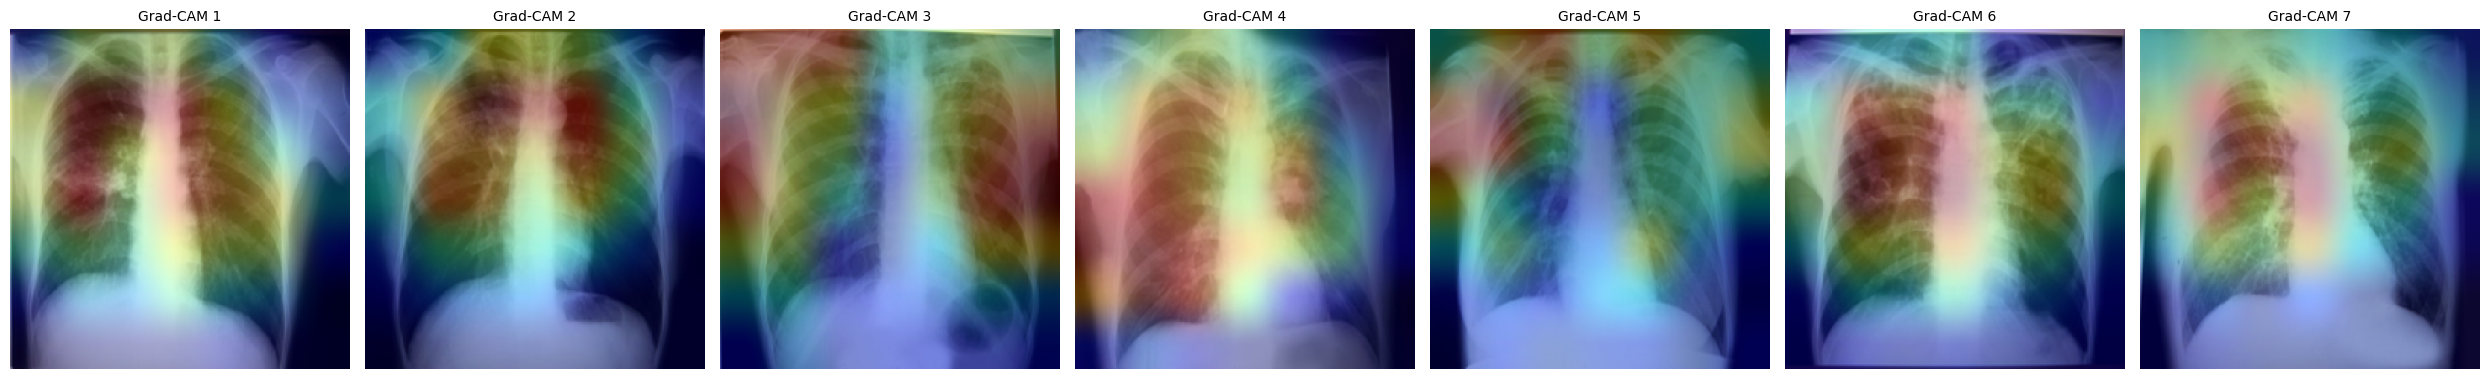

In [17]:
fig, axes = plt.subplots(1, 7, figsize=(25, 5))
for i, img_path in enumerate(sample_images):
    img = image.load_img(img_path, target_size=(224, 224))
    x = np.expand_dims(image.img_to_array(img), axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    # Grad-CAM Visualization
    last_conv = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv = layer.name
            break

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(x)
        class_idx = tf.argmax(preds[0])
        grads = tape.gradient(preds[:, class_idx], conv_out)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.squeeze(conv_out[0] @ pooled_grads[..., tf.newaxis])
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")(np.arange(256))[:, :3]
    jet_heatmap = image.array_to_img(jet[heatmap])
    jet_heatmap = jet_heatmap.resize(img.size)
    jet_heatmap = image.img_to_array(jet_heatmap)
    superimposed = image.array_to_img(jet_heatmap * 0.4 + image.img_to_array(img))

    axes[i].imshow(superimposed)
    axes[i].set_title(f"Grad-CAM {i+1}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()